# Were masks effective?

So, was wearing a mask really necessary? Let's find out.

While the datasets we have are great, we need to do a little of data preparation before we get working on our investigations into the benefits of wearing masks. In particular, we need some way to compare COVID-19 measures across countries. Right now, each country has its own unique path of measures, but we'd like to be able to compare countries that have "similar" policies. So let's get started on that.

First, the policy data comes from the Oxford COVID-19 Government Response Tracker (OxCGRT) dataset, while the progression of COVID-19 comes from the "Our world in data" (owid) dataset.

In [31]:
import pandas as pd
import math
import numpy as np
import sklearn.cluster
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker


data = pd.read_csv(r"../data/OxCGRT_latest_combined.csv", dtype={"RegionName": str, "RegionCode": str})
data["Date"] =  pd.to_datetime(data["Date"], format = '%Y%m%d')

owid_data = pd.read_csv(r"../data/owid-covid-data.csv")
owid_data["date"] = pd.to_datetime(owid_data["date"], format = "%Y-%m-%d")

data.loc[pd.isnull(data["RegionName"]), "RegionName"] = data["CountryName"][pd.isnull(data["RegionName"])]
data.loc[pd.isnull(data["RegionCode"]), "RegionCode"] = data["CountryCode"][pd.isnull(data["RegionCode"])]

## Data exploration

Now that the data is loaded, let's see whether we can cluster policies together. First, let's look at the reproduction rate of COVID-19 at the moment that the most stringent measures were put into place across countries. For now, let's assume that countries that never put the most stringent measures into place were waiting until the reproduction rate would hit 6 (just over the maximum rate in the dataset). Note that the following code may take some time to complete.

In [2]:
triggers = {"C1": 3, "C2": 3, "C4": 4, "C3": 2, "C5": 2, "C6": 3, "C7": 2, "C8": 4, "E1": 2, "E2": 2, "H2": 3, "H3": 2, "H6": 4}

severity_triggers = pd.DataFrame({"iso_code": data["CountryCode"].unique(), "continent": "None"})

for key in triggers:
    severity_triggers[key] = 6.0

for index, row in severity_triggers.iterrows():
    continent_data = owid_data["continent"][owid_data["iso_code"] == row["iso_code"]]
    if continent_data.shape[0] > 0:
        severity_triggers.at[index, "continent"] = continent_data.iloc[0]
    for key in triggers:
        measure_dates = data["Date"][(data["CountryCode"] == row["iso_code"]) & (data[key + "_combined_numeric"] >= triggers[key])]
        if measure_dates.shape[0] > 0:
            new_value = owid_data["reproduction_rate"][(owid_data["iso_code"] == row["iso_code"]) & (owid_data["date"] == min(measure_dates))].mean()
            if (not math.isnan(new_value)):
                severity_triggers.at[index, key] = new_value

Alright, now that we how quickly these were put into place (i.e. at what reproduction rate government decided on the most stringent measures), let's see about differences across continents.

In [3]:
k_means = sklearn.cluster.KMeans(n_clusters = 3)
severity_triggers["policy_cluster"] = k_means.fit_predict(severity_triggers[triggers.keys()])

pd.crosstab(severity_triggers["policy_cluster"], severity_triggers["continent"])

continent,Africa,Asia,Europe,None,North America,Oceania,South America
policy_cluster,,,,,,,
0,15,13,6,4,7,6,2
1,28,15,13,0,9,0,7
2,8,19,24,0,5,2,3


It seems that policies were strongly dependent across continents. Unfortunately, so was the progression of COVID-19. Clustering policies together across all counties in the world risks conflating effects. So instead, we will restrict ourselves to Europe. While this doesn't solve the problem entirely, at least the European countries faced a similar COVID-19 threat at similar points in time.

So we'll compare the policies of European countries, and especially the mask wearing policies. But other policies also had significant effects (Brauner et al, 2021, Science). In particular, keeping schools closed, working from home, and restricting gatherings could have a big effect, and those policy measures are probably not independent of mask wearing policy. So we should control for these effects.

In summary, we need some way of comparing policies on school closings, working from home, gatherings, and mask wearing across European countries. This is where clustering comes in.

In [34]:
countries_to_include = data[data["CountryCode"].isin(owid_data[owid_data["continent"] == "Europe"]["iso_code"])]["RegionCode"].unique()

cluster_vars = {"C1_combined_numeric":9, "C2_combined_numeric":9, "C4_combined_numeric":9, "H6_combined_numeric":9}

data_mask = data["RegionCode"].isin(countries_to_include)
policy_clusters = pd.DataFrame({"RegionCode": countries_to_include})
k_means_clusters = {}

for cluster_var in cluster_vars:
    policy_table = data[data_mask].pivot(index="RegionCode", columns="Date", values=cluster_var)
    policy_table[policy_table.isnull()] = 0
    k_means = sklearn.cluster.KMeans(n_clusters = cluster_vars[cluster_var])
    policy_clusters[cluster_var+"_cluster"] = k_means.fit_predict(policy_table)
    policy_clusters[cluster_var+"_cluster"] = policy_clusters[cluster_var+"_cluster"].astype("category")
    k_means_clusters[cluster_var] = k_means.cluster_centers_

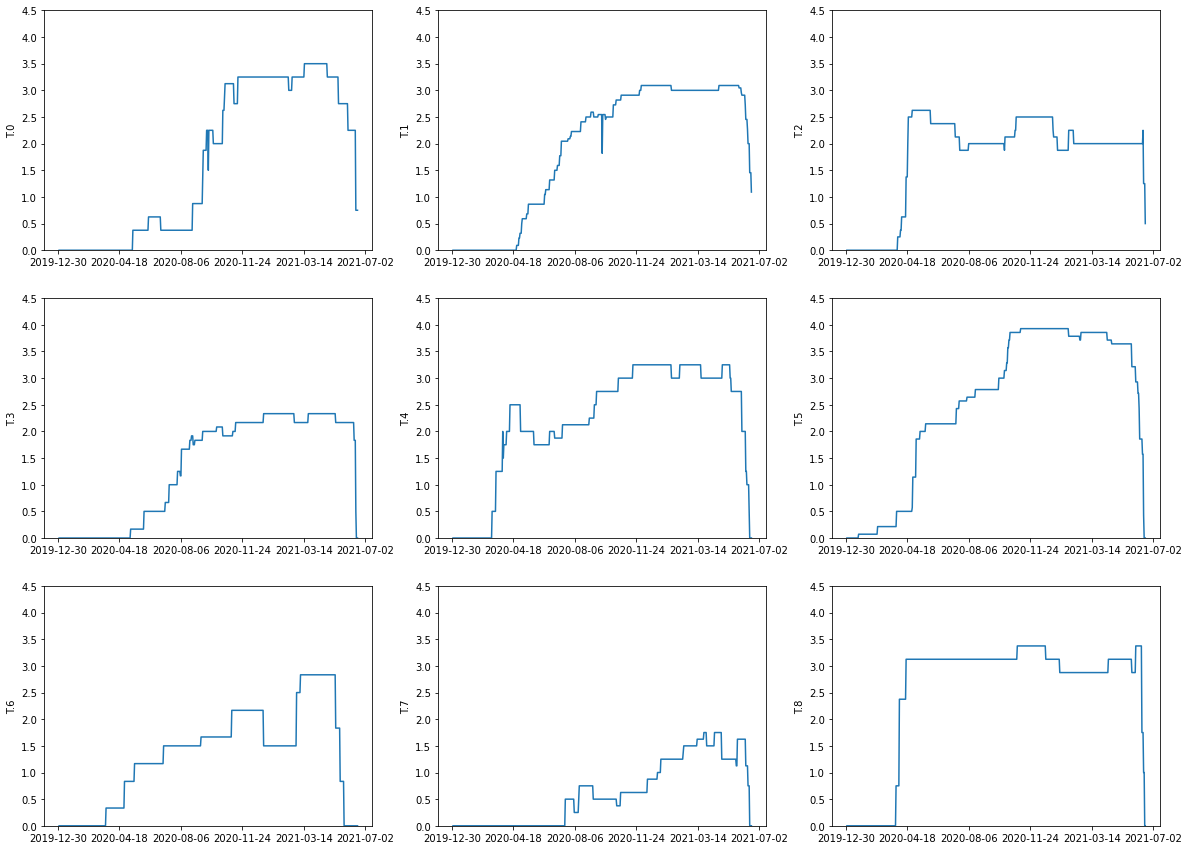

In [35]:
plot_vars = {"H6_combined_numeric":4}

n_clusters = k_means_clusters["H6_combined_numeric"].shape[0]
n_cell = math.ceil(math.sqrt(n_clusters))
fig, axs = plt.subplots(nrows = math.ceil(n_clusters/n_cell), ncols = n_cell, figsize=(20,15))
data_slice = data[data["CountryCode"]=="NLD"]
x = pd.to_datetime(data_slice["Date"], format = '%Y%m%d')

for i in range(n_cell):
    for j in range(n_cell):
        if (i*n_cell + j < n_clusters):
            for plot_var in plot_vars:
                axs[i,j].plot(x,k_means_clusters[plot_var][i*n_cell + j])
            axs[i,j].set_ylim(0,4.5)
            axs[i,j].set_ylabel("T."+str(i*n_cell + j))
            axs[i,j].xaxis.set_major_locator(ticker.MultipleLocator(110)) # Set density of x-axis tickers
plt.savefig("../images/masking_clusters.png")

The graphs above show the "prototypical" progression of mask wearing policies of the 9 clusters we estimates. Why 9? Because we want to have enough European countries per group to compare countries that are similar, but also enough groups to compare across European countries that are different. This is not to say that 8 or 10 would be worse than 9, but neither 3 nor 30 would be a choice that would lead to many insights.

The graphs above look similar, but there are differences. One main difference is the moment at which mask wearing became recommended (value 1 or higher), and when it became required (value 2 or higher). One cluster represents countries that were quick to require masks (March or April 2020), while other clusters represent countries that took until the summer of 2020 before taking mask wearing seriously.

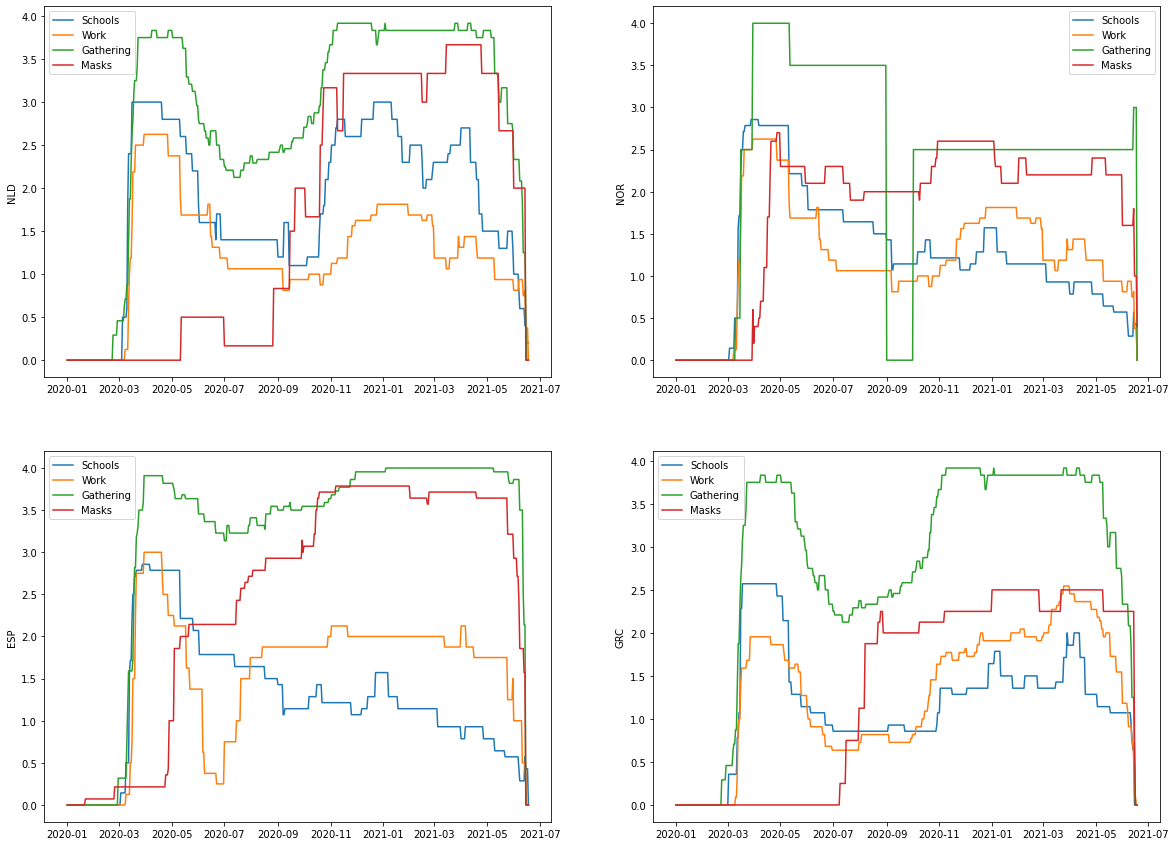

In [19]:
regions = [35, 36, 12, 22]
#regions = [198, 199, 124, 141]
labels = {"C1": "Schools", "C2": "Work", "C4": "Gathering", "H6": "Masks"}

n_cell = math.ceil(math.sqrt(len(regions)))
fig, axs = plt.subplots(nrows = math.ceil(len(regions)/n_cell), ncols = n_cell, figsize=(20,15))

for i in range(n_cell):
    for j in range(n_cell):
        if (i*n_cell + j < len(regions)):
            for plot_var in cluster_vars:
                axs[i,j].plot(x,k_means_clusters[plot_var][policy_clusters.loc[regions[i*n_cell + j]][plot_var+"_cluster"]], label=labels[plot_var[0:2]])
                axs[i,j].set_ylabel(policy_clusters.loc[regions[i*n_cell + j]]["RegionCode"])
            axs[i,j].legend()
plt.savefig("../images/country_cluster_examples.png")


In the graphs above, we plot the policy graphs corresponding to their clusters for 4 countries. At the bottom of this page, we compare the actual and estimated policy of the Netherlands in more detail.

# COVID-19 progression

Next, we add variables for COVID-19 progression. In addition, we also add "time shifted" variables to our dataset. Based on our research, it should take about 10 days before the effects of a policy can be seen in COVID-19 case data. The time shifted variables allow us to investigate this further.

In [36]:
time_shift = 10

#data = pd.read_csv(r"../data/OxCGRT_latest_combined.csv", dtype={"RegionName": str, "RegionCode": str})
#data.loc[pd.isnull(data["RegionName"]), "RegionName"] = data["CountryName"][pd.isnull(data["RegionName"])]
#data.loc[pd.isnull(data["RegionCode"]), "RegionCode"] = data["CountryCode"][pd.isnull(data["RegionCode"])]
full_data = data.merge(policy_clusters, on="RegionCode")
full_data['Date'] = pd.to_datetime(full_data['Date'], format = '%Y%m%d')
full_data = full_data.rename(columns={"CountryCode":"iso_code", "Date":"date"}).set_index(["iso_code", "date"])
full_data["first_wave"] = full_data.index.get_level_values(1) < pd.to_datetime("2020-07-01")
print("Cluster results have been merged")

owid_data = pd.read_csv(r"../data/owid-covid-data.csv")
owid_data["date"] = pd.to_datetime(owid_data["date"], format = "%Y-%m-%d")
full_data = full_data.merge(owid_data.set_index(["iso_code", "date"]), left_index=True, right_index=True)
print("'Our world in data' information has been merged with the Oxford COVID-19 Government Response Tracker data")

owid_data = pd.read_csv(r"../data/owid-covid-data.csv")
owid_data["date"] = pd.to_datetime(owid_data["date"], format = "%Y-%m-%d") - pd.Timedelta(days = time_shift)
owid_data = owid_data.set_index(["iso_code", "date"])
owid_data.columns = owid_data.columns + "_shifted"
responders = (pd.DataFrame(owid_data.columns).iloc[np.r_[9,10,13,14,26,29,37]]).values.tolist()
full_data = full_data.merge(owid_data[[y for x in responders for y in x]], left_index=True, right_index=True)
print("Time shift variables have been merged")
print("All done! Enjoy your dataset")

Cluster results have been merged
'Our world in data' information has been merged with the Oxford COVID-19 Government Response Tracker data
Time shift variables have been merged
All done! Enjoy your dataset


With all data loaded, we can now prepare the main course: panel regression. We want to know whether wearing masks was useful, so let's see whether policies influenced the number of new COVID-19 cases. To make sure we're not measuring the effects of schools closing, working from home, or gathering restrictions, we take those policy measures into account. Moreover, since these measures take some time to take effect, we look at the 10 day shifted number of new cases.

The number of new cases may also depend on the testing policy, so we also control for this effect. Finally, we add time as a random effect, allowing us to account for the fact that over time, there may be fluctuations in the (global) number of COVID-19 cases.

In [49]:
from linearmodels import PanelOLS

inclusion_mask = full_data["continent"] == "Europe"
inclusion_mask = inclusion_mask & ~pd.isnull(full_data["H6_combined"])

full_data["H2_symptoms"] = full_data["H2_combined"] == 2
full_data["H2_open_testing"] = full_data["H2_combined"] == 3
full_data["H3_combined"] = full_data["H3_combined"].astype("category")


regression = PanelOLS.from_formula('new_cases_per_million_shifted ~ 1 + total_cases_per_million + H2_open_testing + C1_combined + C2_combined_numeric_cluster + C2_combined +  C4_combined + H6_combined + H6_combined_numeric_cluster + TimeEffects', data=full_data[inclusion_mask], drop_absorbed=True)
print(regression.fit())

c:\users\xoxix\appdata\local\programs\python\python39\lib\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                                PanelOLS Estimation Summary                                
Dep. Variable:     new_cases_per_million_shifted   R-squared:                        0.1015
Estimator:                              PanelOLS   R-squared (Between):              0.7807
No. Observations:                          21490   R-squared (Within):               0.0790
Date:                           Sun, Jun 27 2021   R-squared (Overall):              0.1313
Time:                                   07:56:42   Log-likelihood                -1.441e+05
Cov. Estimator:                       Unadjusted                                           
                                                   F-statistic:                      50.361
Entities:                                     42   P-value                           0.0000
Avg Obs:                                  511.67   Distribution:                F(47,20942)
Min Obs:                                  301.00                                

If everything went correctly, the Panel OLS above should show that the policy cluster (H6_combined_numeric_cluster) has a significant effect on the number of new cases (per million), even if we control for the policies on school closing, working from home, gatherings, testing, as well as the total cases (per million).

Moreover, by comparing the cluster prototype plots above with the regression coefficients, you can see that policies that clusters that started late with requiring masks are associated with higher daily cases of COVID-19 (everything else being equal). By changing the dependent variable to the new number of deaths, we find that this effect also translates into more daily deaths for countries that started later with requiring masks. Taken together, this is compelling evidence that wearing a mask was effective.

## Figures

Some figures to show the data in more detail

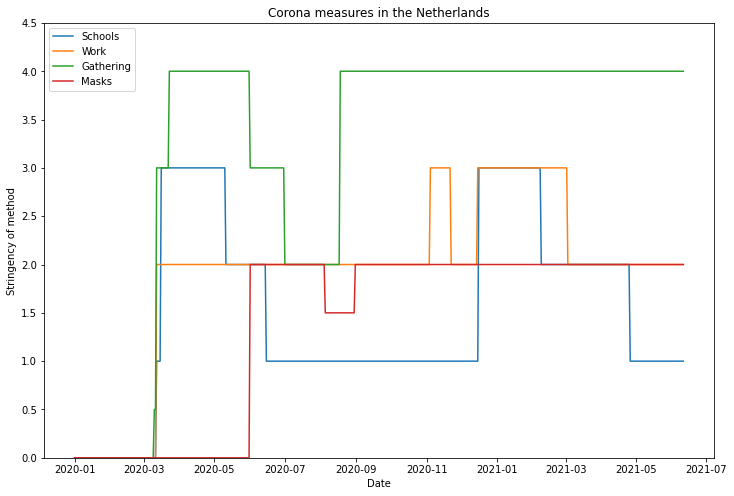

In [9]:
data_slice = data[data["CountryCode"]=="NLD"]
x = pd.to_datetime(data_slice["Date"], format = '%Y%m%d')

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, data_slice["C1_combined_numeric"], label="Schools")
ax.plot(x, data_slice["C2_combined_numeric"], label="Work")
ax.plot(x, data_slice["C4_combined_numeric"], label="Gathering")
ax.plot(x, data_slice["H6_combined_numeric"], label="Masks")
ax.set_ylim(0,4.5)
ax.legend()
ax.set_ylabel("Stringency of method")
ax.set_xlabel("Date")
ax.set_title("Corona measures in the Netherlands")
plt.savefig("../images/NLD_measures.png")

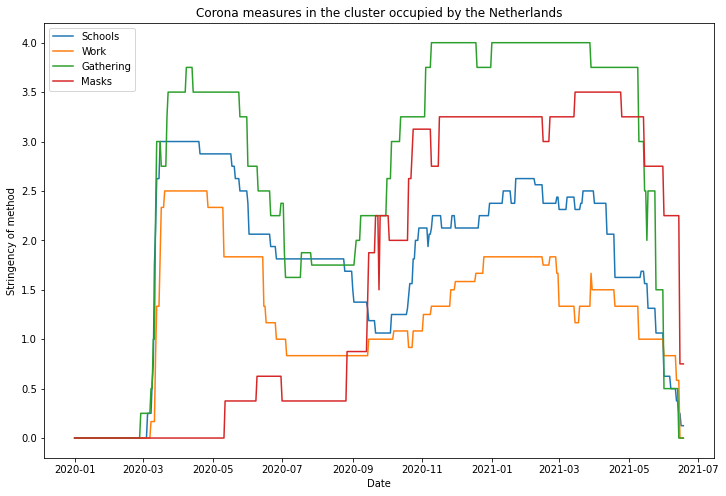

In [10]:
region = 35
labels = ["Schools", "Work", "Gathering", "Masks"]

n_cell = math.ceil(math.sqrt(len(regions)))
fig, ax = plt.subplots(figsize=(12,8))

k=0
for plot_var in cluster_vars:
    ax.plot(x, k_means_clusters[plot_var][policy_clusters.loc[region][plot_var+"_cluster"]], label=labels[k])
    k += 1
    ax.set_ylabel(policy_clusters.loc[region]["RegionCode"])
ax.legend()
ax.set_ylabel("Stringency of method")
ax.set_xlabel("Date")
ax.set_title("Corona measures in the cluster occupied by the Netherlands")
plt.savefig("../images/NLD_cluster.png")


# First wave versus second wave

The dataset is tricky to interpret when considering the effect of measures. For example, suppose you want to know whether closing schools is really all that necessary. So you set out to find out whether there is an effect of school closing policy (C1) on the reproduction rate of COVID-19. When you split the data into first wave (up to and including June 2020) and second wave (July 2020 and onwards), you'll find something interesting...

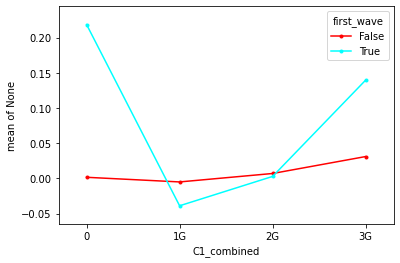

In [11]:
from statsmodels.graphics.factorplots import interaction_plot

selection_mask = full_data["continent"] == "Europe"
selection_mask = selection_mask & ~pd.isnull(full_data["C1_combined"])
selection_mask = selection_mask & ~(full_data["C1_combined"].isin(["1T","2T","3T"]))

fig =  interaction_plot(full_data[selection_mask]["C1_combined"],
                        full_data[selection_mask]["first_wave"], 
                        full_data[selection_mask]["reproduction_rate"]-full_data[selection_mask]["reproduction_rate_shifted"])


The graph above does not control for anything. It simply looks at the mean change in reproduction rate (shifted by 10 days) depending on the school closing policy across the two waves. The first wave shows a big effect in the first wave (teal line), but barely any effect in the second wave (red line). Since the graph doesn't control for anything, there could be many alternative explanations for this effect. It could be that other measures coincided with opening or closing schools, which could explain the effect in the first wave, the second wave, or both. From this graph, we have no way of knowing for sure.

# School's out for... spring?

How long did European countries wait before closing schools?

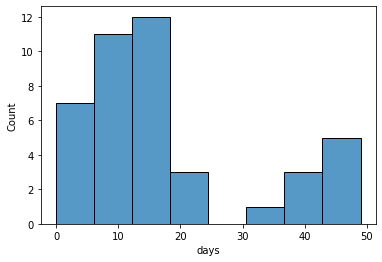

In [12]:
import seaborn as sb

days_until_schools_close = pd.DataFrame({"iso_code":  full_data.index.get_level_values(0).unique(), "days": math.nan})
for index, row in days_until_schools_close.iterrows():
    cases_data = full_data.index.get_level_values(1)[(full_data.index.get_level_values(0) == row["iso_code"]) & (full_data["total_cases"]>0)]
    school_close_data = full_data.index.get_level_values(1)[(full_data.index.get_level_values(0) == row["iso_code"]) & (full_data["C1_combined_numeric"]>=2)]
    if (cases_data.shape[0] > 0 and school_close_data.shape[0] > 0):
        days_until_schools_close.at[index, "days"] = (min(school_close_data) - min(cases_data)).days

sb.histplot(data=days_until_schools_close, x="days");

In [13]:
days_until_schools_close["iso_code"][days_until_schools_close["days"] > 31]

3     BEL
6     BLR
10    DEU
12    ESP
14    FIN
15    FRA
17    GBR
36    RUS
41    SWE
Name: iso_code, dtype: object

There are 9 European countries that waited for more than a month between the first confirmed case of COVID-19 in their country and closing schools.  But did closing schools slow down the COVID-19 infection rates? Let's check the reproduction rates.

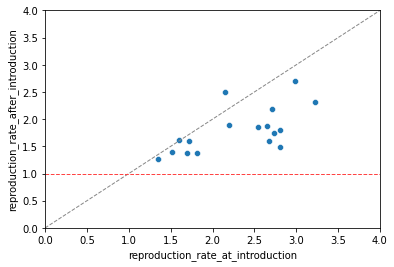

In [14]:
time_shift = 10 #days

data = full_data.reset_index()
days_until_schools_close = pd.DataFrame({"iso_code":  data["iso_code"].unique(), "continent":  data["iso_code"].unique(), "days": math.nan, "new_cases_at_introduction": math.nan})
for index, row in days_until_schools_close.iterrows():
    continent_data = data["continent"][data["iso_code"] == row["iso_code"]]
    if continent_data.shape[0] > 0:
        days_until_schools_close.at[index, "continent"] = continent_data.iloc[0]
    cases_data = data["date"][(data["iso_code"] == row["iso_code"]) & (data["total_cases"]>0)]
    event_data = data["date"][(data["iso_code"] == row["iso_code"]) & (data["C1_combined_numeric"]>=2)]
    if event_data.shape[0] > 0:
        days_until_schools_close.at[index, "new_cases_at_introduction"] = sum(data["new_cases_per_million"][(data["iso_code"] == row["iso_code"]) & (data["date"]==min(event_data))])
        days_until_schools_close.at[index, "reproduction_rate_at_introduction"] = data["reproduction_rate"][(data["iso_code"] == row["iso_code"]) & (data["date"]==min(event_data))].mean()
        days_until_schools_close.at[index, "mean_new_cases_before_introduction"] = data["new_cases_per_million"][(data["iso_code"] == row["iso_code"]) & (data["date"]<min(event_data))].mean()
        days_until_schools_close.at[index, "mean_reproduction_rate_before_introduction"] = data["reproduction_rate"][(data["iso_code"] == row["iso_code"]) & (data["date"]<min(event_data))].mean()
        days_until_schools_close.at[index, "new_cases_after_introduction"] = data["new_cases_per_million"][(data["iso_code"] == row["iso_code"]) & (data["date"]==min(event_data) + pd.Timedelta(days = time_shift))].mean()
        days_until_schools_close.at[index, "reproduction_rate_after_introduction"] = data["reproduction_rate"][(data["iso_code"] == row["iso_code"]) & (data["date"]==min(event_data) + pd.Timedelta(days = time_shift))].mean()
        if cases_data.shape[0] > 0:
            days_until_schools_close.at[index, "days"] = (min(event_data) - min(cases_data)).days


ax = sb.scatterplot(data=days_until_schools_close, x='reproduction_rate_at_introduction', y='reproduction_rate_after_introduction')
ax.set_ylim(ymin=0, ymax=4)
ax.set_xlim(xmin=0, xmax=4)
ax.plot([0,4],[0,4], color="#888888", linestyle="dashed", linewidth=1)
ax.plot([0,4],[1,1], color="#FF4444", linestyle="dashed", linewidth=1);

The graph shows that reproduction rates 10 days after schools closed down were lower than the moment the schools were closed. The measure seems to have helped.

In [ ]:
time_shift = 10 #days

data = full_data.reset_index()
days_until_schools_close = pd.DataFrame({"iso_code":  data["iso_code"].unique(), "continent":  data["iso_code"].unique(), "days": math.nan, "new_cases_at_introduction": math.nan})
for index, row in days_until_schools_close.iterrows():
    continent_data = data["continent"][data["iso_code"] == row["iso_code"]]
    if continent_data.shape[0] > 0:
        days_until_schools_close.at[index, "continent"] = continent_data.iloc[0]
    cases_data = data["date"][(data["iso_code"] == row["iso_code"]) & (data["total_cases"]>0)]
    event_data = data["date"][(data["iso_code"] == row["iso_code"]) & (data["C1_combined_numeric"]>=2)]
    if event_data.shape[0] > 0:
        days_until_schools_close.at[index, "new_cases_at_introduction"] = sum(data["new_cases_per_million"][(data["iso_code"] == row["iso_code"]) & (data["date"]==min(event_data))])
        days_until_schools_close.at[index, "reproduction_rate_at_introduction"] = data["reproduction_rate"][(data["iso_code"] == row["iso_code"]) & (data["date"]==min(event_data))].mean()
        days_until_schools_close.at[index, "mean_new_cases_before_introduction"] = data["new_cases_per_million"][(data["iso_code"] == row["iso_code"]) & (data["date"]<min(event_data))].mean()
        days_until_schools_close.at[index, "mean_reproduction_rate_before_introduction"] = data["reproduction_rate"][(data["iso_code"] == row["iso_code"]) & (data["date"]<min(event_data))].mean()
        days_until_schools_close.at[index, "new_cases_after_introduction"] = data["new_cases_per_million"][(data["iso_code"] == row["iso_code"]) & (data["date"]==min(event_data) + pd.Timedelta(days = time_shift))].mean()
        days_until_schools_close.at[index, "reproduction_rate_after_introduction"] = data["reproduction_rate"][(data["iso_code"] == row["iso_code"]) & (data["date"]==min(event_data) + pd.Timedelta(days = time_shift))].mean()
        if cases_data.shape[0] > 0:
            days_until_schools_close.at[index, "days"] = (min(event_data) - min(cases_data)).days


ax = sb.scatterplot(data=days_until_schools_close, x='reproduction_rate_at_introduction', y='reproduction_rate_after_introduction')
ax.set_ylim(ymin=0, ymax=4)
ax.set_xlim(xmin=0, xmax=4)
ax.plot([0,4],[0,4], color="#888888", linestyle="dashed", linewidth=1)
ax.plot([0,4],[1,1], color="#FF4444", linestyle="dashed", linewidth=1);

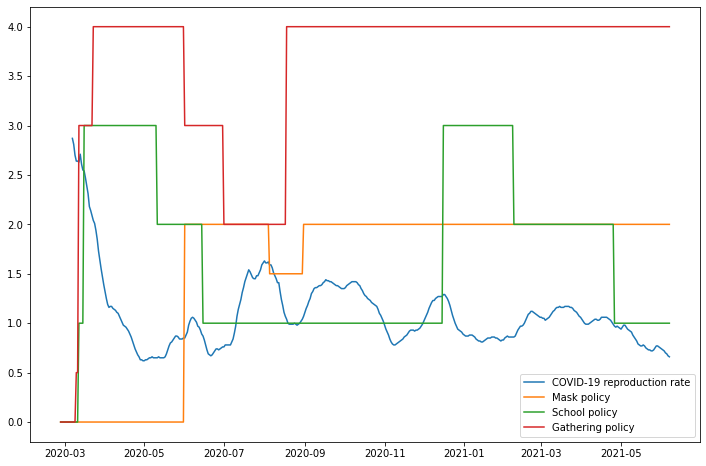

In [67]:
data_slice = full_data[full_data.index.get_level_values(0)=="NLD"]
data_slice["reproduction_rate"].head()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data_slice.index.get_level_values(1), data_slice["reproduction_rate"], label="COVID-19 reproduction rate")
ax.plot(data_slice.index.get_level_values(1), data_slice["H6_combined_numeric"], label="Mask policy")
ax.plot(data_slice.index.get_level_values(1), data_slice["C1_combined_numeric"], label="School policy")
ax.plot(data_slice.index.get_level_values(1), data_slice["C4_combined_numeric"], label="Gathering policy")
ax.legend()

plt.savefig("../images/NLD_reproduction_rate_and_policies.png")